# **Atividade 2 - Assinatura de produto bancário**

### Autora: Larissa Aquino*

*As análises foram desenvolvidas em colaboração com Letícia Octaviano,  mas entregue de maneira individual.

In [1]:
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import scipy
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler

# modelos
from sklearn.dummy import DummyClassifier
from sklearn import linear_model
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree 
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, CategoricalNB
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.svm import SVC

# selecao modelos
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1
from sklearn.metrics import brier_score_loss as brier
from sklearn.metrics import log_loss
from sklearn import metrics  
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score as precision
from sklearn.metrics import recall_score as recall
from sklearn.metrics import plot_roc_curve

import missingno as msno
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

pd.set_option('precision', 3)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
def model_prediction(model, X_test, p_cut, model_name):
  if(model_name == 'random_forest'):
    y_prob = model.predict(X_test)
  else:
    y_prob = model.predict_proba(X_test)[:,1]
  y_pred = []
  for i in y_prob:
    if i >= p_cut:
      y_pred.append(1)
    else:
      y_pred.append(0)
  return y_pred

def plot_roc_curve(y_true, y_pred_proba):
  fpr, tpr, thresholds = metrics.roc_curve(y_true,  y_pred_proba)
  auc = metrics.roc_auc_score(y_true, y_pred_proba)

  roc = pd.DataFrame({
      'fpr' : fpr,
      'tpr' : tpr, 
      'tf' : tpr - (1-fpr),
      'thresholds' : thresholds
      })

  plt.plot(roc['fpr'],roc['tpr'],label="auc="+str(auc))
  plt.plot( [0,1], [0,1], '--r')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

  # optimal threshold
  point = roc.iloc[(roc.tf-0).abs().argsort()[0]]
  cut_off = point['thresholds'].round(2)
  plt.scatter(
      point['fpr'], point['tpr'], color = 'purple', s = 50,
      label = f"optimal threshold  = {point['thresholds'].round(2)}"
      )

  # .5 threshold
  point = roc.iloc[(roc.thresholds-0.5).abs().argsort()[:1][0]]
  plt.scatter(
      point['fpr'], point['tpr'], color = 'orange', s = 50, 
      label = 'threshold = 0.50'
      )
  plt.legend()
  plt.show()
  return cut_off

def plot_confusion_matrix(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"Confusion Matrix \n TN = {tn}, FN = {fn}, TP = {tp}, FP = {tn} \n")
    CM_norm = confusion_matrix(y_test, y_pred, normalize = 'true')
    sns.heatmap(CM_norm, annot=True, cmap="YlGnBu")
    plt.xlabel('predicted label', fontsize= 14)
    plt.ylabel('real label', fontsize= 14)
    plt.show()
    return

def model_evaluation(model, X_test, y_test, X_val, y_val, model_name):
  
  if (model_name == 'random_forest'):
    y_prob = model.predict(X_val)
  else:
    y_prob = model.predict_proba(X_val)[:,1]
  
  #escolhe a probabilidade de corte de acordo com a curva roc usando o conjunto de validação:
  p_cut = plot_roc_curve(y_val, y_prob) 
  print(f"Probabilidade de corte usada: {p_cut}")
  
  # Define o resultado da classificação de acordo com a probabilidade retornada pelo modelo
  # e ponto de corte:
  y_pred = model_prediction(model, X_test, p_cut, model_name)
  
  # Métricas:
  plot_confusion_matrix(y_test, y_pred)
  print(f"\nROC score: {metrics.roc_auc_score(y_test, y_pred)}")
  print(f"\n Accuracy = {acc(y_test,y_pred)}")
  print(f"\n Precision (TP/(TP+FP)) = {precision(y_test,y_pred)}")
  print(f"\n Recall (TP/(TP+FN)) = {recall(y_test,y_pred)}")
  print(f"\n F1 = {metrics.f1_score(y_test, y_pred)}")

  return


# **Análise exploratória**

### Importando e visualizando os dados

In [4]:
df = pd.read_csv(r"/content/bank-additional-full.csv", sep= ";", index_col = None)
df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


A base conta 41188 registros, 20 features (covariáveis) e uma coluna correspondendo a variável dependente, que informa o resultado referente ao status de aquisição do produto bancário. Descrição fornecida para as covariáveis:

> **bank client data:**
>>1 - age (numeric)

>>2 - job : type of job (categorical)

>>3 - marital : marital status (categorical)
>>4 - education (categorical)

>>5 - default: has credit in default? (categorical)

>>6 - housing: has housing loan? (categorical)

>>7 - loan: has personal loan? (categorical)

> ** related with the last contact of the current campaign:**
>>8 - contact: contact communication type (categorical: 'cellular','telephone')

>>9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

>>10 - day_of_week: last contact day of the week 
(categorical)

>>11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.


> **other attributes:**
>>12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

>>13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric)

>>14 - previous: number of contacts performed before this campaign and for this client (numeric)

>>15 - poutcome: outcome of the previous marketing campaign (categorical)

> **social and economic context attributes**
>>16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

>>17 - cons.price.idx: consumer price index - monthly indicator (numeric)

>>18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)

>>19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

>>20 - nr.employed: number of employees - quarterly indicator (numeric)

> **Output variable (desired target)**:
>>21 - y - has the client subscribed a term deposit? (binary)

In [5]:
# Removendo a variável duration, devido a observação indicada acima em sua descrição:
df = df.drop(columns=['duration'])

### Variáveis numéricas

In [6]:
#Verificando a existência de missing values
numerical = ['age', 'pdays', 'previous', 'emp.var.rate', \
             'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
             
print("Quantidade de valores nulos por coluna:\n\n", df[numerical].isnull().sum())

Quantidade de valores nulos por coluna:

 age               0
pdays             0
previous          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
dtype: int64


In [7]:
# Identificando outliers
df[numerical].describe()

,age,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.000,41188.000,41188.000,41188.000,41188.000,41188.000,41188.000,41188.000
mean,40.024,962.475,0.173,0.082,93.576,-40.503,3.621,5167.036
std,10.421,186.911,0.495,1.571,0.579,4.628,1.734,72.252
min,17.000,0.000,0.000,-3.400,92.201,-50.800,0.634,4963.600
25%,32.000,999.000,0.000,-1.800,93.075,-42.700,1.344,5099.100
50%,38.000,999.000,0.000,1.100,93.749,-41.800,4.857,5191.000
75%,47.000,999.000,0.000,1.400,93.994,-36.400,4.961,5228.100
max,98.000,999.000,7.000,1.400,94.767,-26.900,5.045,5228.100


nota-se que a maior parte dos clientes (mais de 75% dos registros) não tiveram contato anterior com as campanhas de telemarketing do banco. Visto que a parcela da base exposta a campanhas previamente é muito baixo, optei por remover esses campos.

In [8]:
df = df.drop(columns=['pdays', 'previous'])

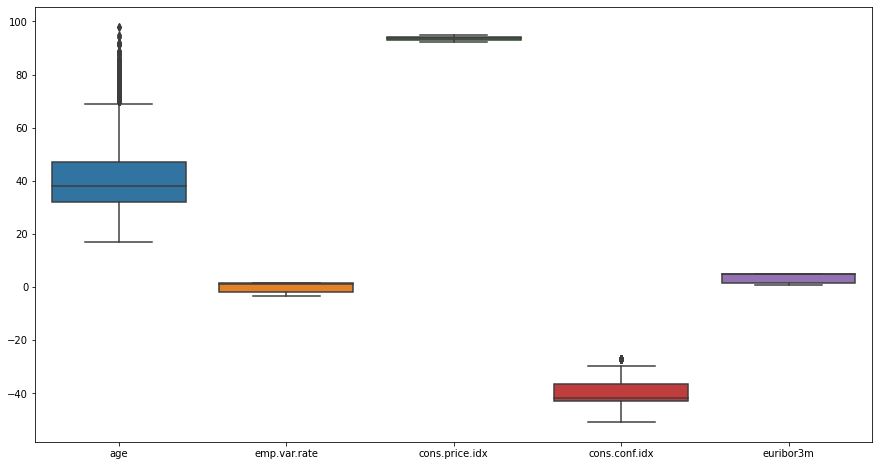

In [9]:
numerical = ['age', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m']
plt.figure(figsize=(15, 8))
sns.boxplot(data = df[numerical])
numerical.append('nr.employed')

### Variáveis Categóricas

In [10]:
# Tratamento variáveis categóricas

categorical = ["job", "marital", "education", "default", "housing", "loan", \
               "contact", "day_of_week", "month", "campaign", "poutcome"]
for column in categorical:
  print("coluna: ", column,"(% por categoria)\n", 100*df[column].value_counts()/len(df['y']), "\n\n")

coluna:  job (% por categoria)
 admin.           25.303
blue-collar      22.468
technician       16.371
services          9.636
management        7.099
retired           4.176
entrepreneur      3.535
self-employed     3.450
housemaid         2.574
unemployed        2.462
student           2.124
unknown           0.801
Name: job, dtype: float64 


coluna:  marital (% por categoria)
 married     60.522
single      28.086
divorced    11.197
unknown      0.194
Name: marital, dtype: float64 


coluna:  education (% por categoria)
 university.degree      29.543
high.school            23.101
basic.9y               14.677
professional.course    12.729
basic.4y               10.139
basic.6y                5.565
unknown                 4.203
illiterate              0.044
Name: education, dtype: float64 


coluna:  default (% por categoria)
 no         79.120
unknown    20.873
yes         0.007
Name: default, dtype: float64 


coluna:  housing (% por categoria)
 yes        52.384
no         45.21

As covariáveis **default** e **poutcome** também serão removidas, por ter maior parte dos resultados idêntincos ou desconhecidos para a base.

In [11]:
df = df.drop(columns = ['default', 'poutcome'])

Por fim, para facilitar o processamento, associaremos os valores tipo texto das categorias a valores numéricos:

In [12]:
categorical = ["job", "marital", "education", "housing", "loan", \
               "contact", "day_of_week", "month", "campaign"]
labelencoder = LabelEncoder()
for column in categorical:
  df[column] = labelencoder.fit_transform(df[column])

df['y'] = labelencoder.fit_transform(df['y'])

Formato final - dados preparados:

In [13]:
df.head(5)

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3,1,0,0,0,1,6,1,0,1.1,93.994,-36.4,4.857,5191.0,0
1,57,7,1,3,0,0,1,6,1,0,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7,1,3,2,0,1,6,1,0,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0,1,1,0,0,1,6,1,0,1.1,93.994,-36.4,4.857,5191.0,0
4,56,7,1,3,0,2,1,6,1,0,1.1,93.994,-36.4,4.857,5191.0,0


### Correlação entre as variáveis

Correlação entre as variáveis numéricas:

---



In [14]:
df[numerical + ['y']].corr()

,age,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.000e+00,-3.707e-04,8.567e-04,0.129,0.011,-0.018,0.030
emp.var.rate,-3.707e-04,1.000e+00,7.753e-01,0.196,0.972,0.907,-0.298
cons.price.idx,8.567e-04,7.753e-01,1.000e+00,0.059,0.688,0.522,-0.136
cons.conf.idx,1.294e-01,1.960e-01,5.899e-02,1.000,0.278,0.101,0.055
euribor3m,1.077e-02,9.722e-01,6.882e-01,0.278,1.000,0.945,-0.308
nr.employed,-1.773e-02,9.070e-01,5.220e-01,0.101,0.945,1.000,-0.355
y,3.040e-02,-2.983e-01,-1.362e-01,0.055,-0.308,-0.355,1.000


Por fim, para evitar multicolinearedade, irei remover as variáveis 'nr.employed' e 'emp.var.rate'da análise, dada a alta correlação correlção com a taxa referência de juros 'euribor3m'.  

In [15]:
df = df.drop(columns = ["nr.employed", "emp.var.rate"])

# **Ajustando Modelos**

In [16]:
# Obtendo matriz com as possíveis covariáveis do modelo
X = df.drop(columns = ["y"]).to_numpy()

# Obtendo o vetor com os resultados
y = df["y"].to_numpy()

# Escolhendo o tamanho da base de treino e de teste com base no intervalo de confiança:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Faz o balanceamento da base de treino, já que há muito mais casos onde y = 0:
rus = RandomUnderSampler(sampling_strategy="not minority", random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

#Divide a base inicial de teste em teste e validação 
#(validação será usada para definir a probabilidade de corte)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.4, random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### Ajuste Regressão Logística

In [17]:
logistica = linear_model.LogisticRegression(max_iter = 100000).fit(X=X_train,y=y_train)

principais features: 
            features  coefs
6          contact -0.799
12       euribor3m -0.637
4          housing -0.081
9         campaign -0.069
7            month -0.041
0              age -0.001
1              job  0.005
5             loan  0.028
8      day_of_week  0.028
3        education  0.041
2          marital  0.045
11   cons.conf.idx  0.067
10  cons.price.idx  0.836


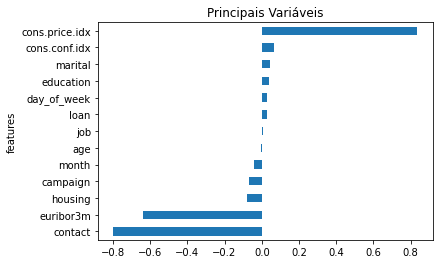

In [18]:
# plotando as variaveis mais importantes
features = df.drop(columns = ["y"]).columns
results_reg = pd.DataFrame(features , columns = ['features'])
results_reg['coefs']= logistica.coef_[0]
results_reg.sort_values(by = ['coefs'], inplace = True, ascending = True)
results_reg.tail(15).plot(kind = 'barh', x = 'features', y = 'coefs', title = 'Principais Variáveis', legend = None)
print('principais features: \n ', results_reg.tail(15))


### Ajuste Árvore de Decisões

Melhores Parametros: {'max_depth': 4}


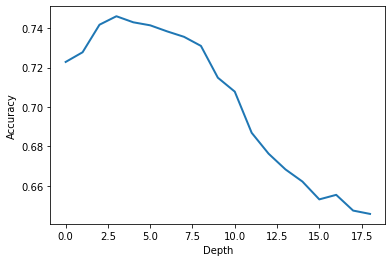

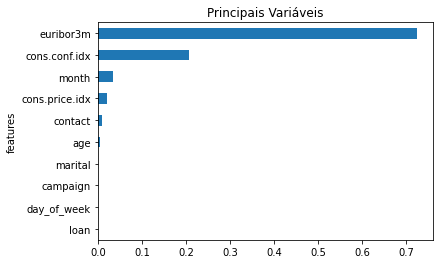

In [19]:
arvore = DecisionTreeClassifier(random_state = 0)

# otimização de hiperparametros
param_grid = {'max_depth':np.arange(1, 20)}
arvore_gscv = GridSearchCV(arvore, param_grid, cv = 5, scoring='accuracy')
arvore_gscv.fit(X_train, y_train)

# resultado
print(f"Melhores Parametros: {arvore_gscv.best_params_}")

plt.figure()
plt.plot(arvore_gscv.cv_results_['mean_test_score'],linewidth=2)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()

# utilizando o melhores parametros
arvore.set_params(**arvore_gscv.best_params_)
arvore.fit(X_train,y_train)

# plotando as variaveis mais importantes
features = df.drop(columns = ["y"]).columns
results_arvore = pd.DataFrame(features , columns = ['features'])
results_arvore['importance'] = np.abs(pd.Series(arvore.feature_importances_))
results_arvore.sort_values(by = ['importance'], inplace = True, ascending = True)
results_arvore.tail(10).plot(kind = 'barh', x = 'features', y = 'importance', title = 'Principais Variáveis', legend = None)
plt.show()

Visualizando a árvore:

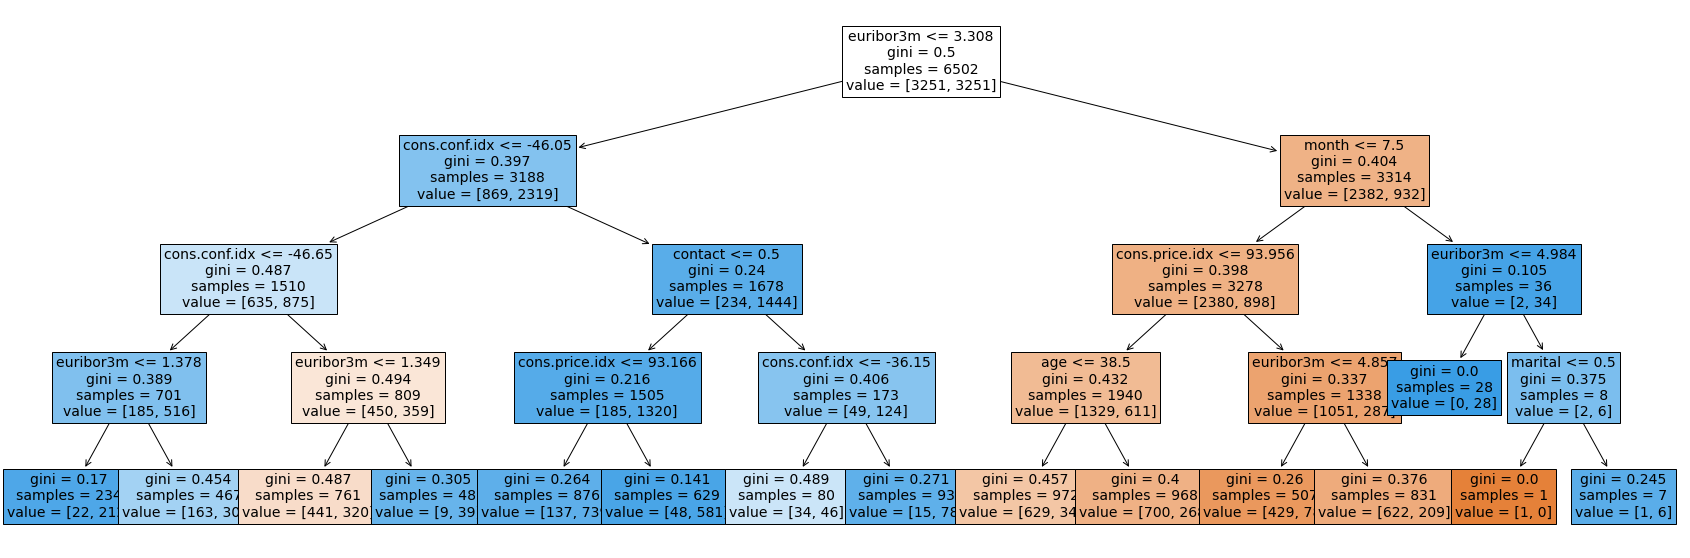

In [20]:
features = df.drop(columns = ["y"]).columns
fig = plt.figure(figsize=(30,10))
_ = tree.plot_tree(arvore, feature_names=features,  filled=True, fontsize=14)


### Ajuste Random Forest

In [21]:
from sklearn.ensemble import RandomForestRegressor

# criando modelo
floresta = RandomForestRegressor(random_state = 0)

# otimização de hiperparametros
param_grid = [{'max_depth':np.arange(1, 20)}]
floresta_gscv = GridSearchCV(floresta, param_grid, cv=5,scoring=make_scorer(mse,greater_is_better=False))
start = time.time()
floresta_gscv.fit(X_train, y_train)
end = time.time()
print("parâmetros :", floresta_gscv.best_params_, "\n Tempo de execução (s): ", (end-start))

parâmetros : {'max_depth': 7} 
 Tempo de execução (s):  86.48979496955872


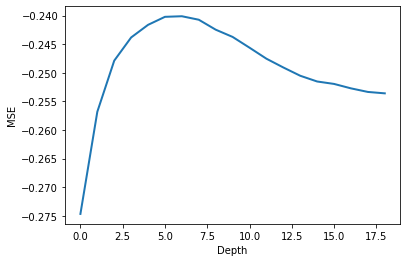

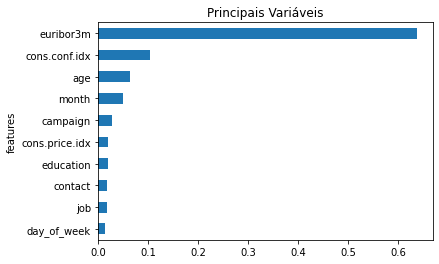

In [22]:
plt.figure()
plt.plot(floresta_gscv.cv_results_['mean_test_score'],linewidth=2)
plt.xlabel('Depth')
plt.ylabel('MSE')
plt.show()

# utilizando o melhores parametros
floresta.set_params(**floresta_gscv.best_params_)
floresta.fit(X_train,y_train)

# plotando as variaveis mais importantes
features = df.drop(columns = ["y"]).columns
results_forest = pd.DataFrame(features , columns = ['features'])
results_forest['importance'] = np.abs(pd.Series(floresta.feature_importances_))
results_forest.sort_values(by = ['importance'], inplace = True, ascending = True)
results_forest.tail(10).plot(kind = 'barh', x = 'features', y = 'importance', title = 'Principais Variáveis', legend = None)
plt.show()

Em geral nota-se uma forte influência das variáveis atreladas ao mercado, como a taxa de juros (euribor) e o Consumer confidence index (cons.conf.idx). Em termos de negócio, isso é bastante ruim visto que não há como controlar esses fatores. Dentre as demais variáveis destacam-se idade, campanha, nível de educação e *housing*, mas há grande discordância da ordem de importância delas para os diferentes modelos. 

# **Comparação dos Modelos**

### **Significado das métricas dos modelos para o negócio**:



**Acurácia**: Fornece uma visão geral da probabilidade do resultado do modelo estar correto, mas sem considerar características importantes sobre o tipo de erro que o modelo comete.

**Precision**: considerando que vamos entrar em contato com os clientes que o modelo indicar como positivo (propensos a fechar negócio). A precisão indica o percentual de clientes que realmente vai contratar o empréstimo. Logo uma precisão baixa implica em alto custo com telemarketing e baixo retorno de vendas.

**Recall**: indica que percentual dos clientes propensos a fechar negócio de fato estamos conseguindo indentificar. Logo um baixo recall significa que estamos deixando de entrar em contato com muitos clientes que estariam propensos a fechar negócio.

**F1**: Corresponde a média harmônica entre precision e recall. Ao otimizar essa métrica estamos buscando um equilíbrio entre **reduzir custos**, ao considerar apenas clientes muito qualificados (precision), e **amplificar possibilidade de lucro**, ao não deixar para trás muitos clientes propensos a fechar negócio (recall).

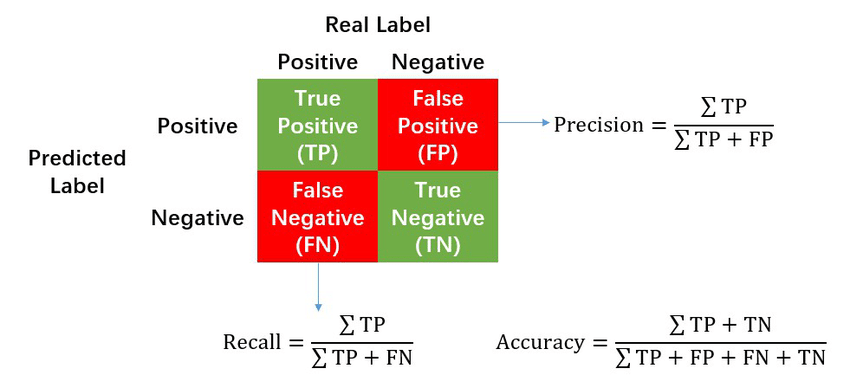


### Dummy Classifier

Modelo que implementa regras simples de classificação, sem nenhum inteligência estatística. Usado apenas para auxíliar no entendimento de quanto os modelos trouxeram de ganho de qualidade na classificação:


%%%%%%%%%%%%%%%%%%%%% DUMMY CLASSIFIER: %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


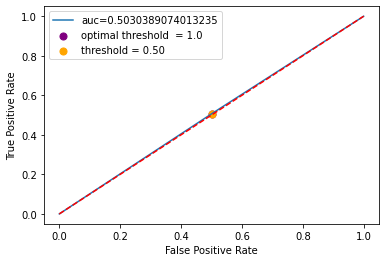

Probabilidade de corte usada: 1.0
Confusion Matrix 
 TN = 2166, FN = 259, TP = 272, FP = 2166 



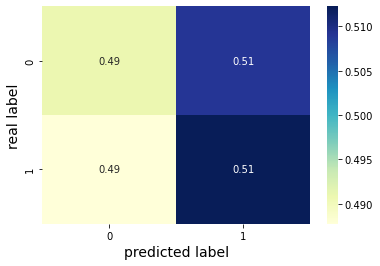


ROC score: 0.5015874357385183

 Accuracy = 0.49322273922718995

 Precision (TP/(TP+FP)) = 0.10802223987291501

 Recall (TP/(TP+FN)) = 0.512241054613936

 F1 = 0.17841915382092488


In [23]:
dummy = DummyClassifier(strategy="stratified")
dummy.fit(X_train, y_train)
print("\n%%%%%%%%%%%%%%%%%%%%% DUMMY CLASSIFIER: %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
model_evaluation(dummy, X_test, y_test, X_val, y_val, "dummy")

### Regressão Logística


%%%%%%%%%%%%%%%%%%%%% LOGISTIC REGRESSION: %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


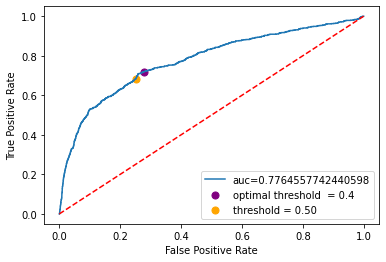

Probabilidade de corte usada: 0.4
Confusion Matrix 
 TN = 3091, FN = 164, TP = 367, FP = 3091 



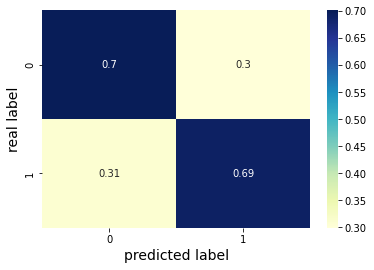


ROC score: 0.6958690388992185

 Accuracy = 0.6995751567873761

 Precision (TP/(TP+FP)) = 0.21741706161137442

 Recall (TP/(TP+FN)) = 0.6911487758945386

 F1 = 0.3307796304641731


In [24]:
print("\n%%%%%%%%%%%%%%%%%%%%% LOGISTIC REGRESSION: %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
model_evaluation(logistica, X_test, y_test, X_val, y_val, "logistic_regression")

### Árvore de Decisões


%%%%%%%%%%%%%%%%%%%%% DECISION TREE: %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


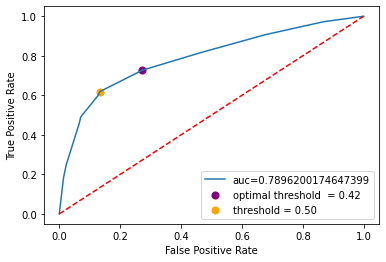

Probabilidade de corte usada: 0.42
Confusion Matrix 
 TN = 3127, FN = 165, TP = 366, FP = 3127 



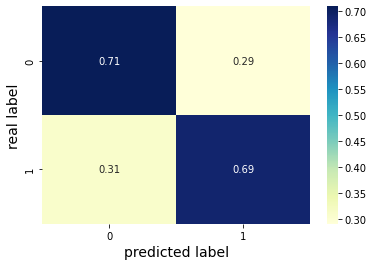


ROC score: 0.6990072017251359

 Accuracy = 0.7066558769977747

 Precision (TP/(TP+FP)) = 0.2216838279830406

 Recall (TP/(TP+FN)) = 0.6892655367231638

 F1 = 0.3354720439963337


In [25]:
print("\n%%%%%%%%%%%%%%%%%%%%% DECISION TREE: %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
model_evaluation(arvore, X_test, y_test, X_val, y_val, "decision_tree")

### Floresta


%%%%%%%%%%%%%%%%%%%%% RANDOM FOREST: %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


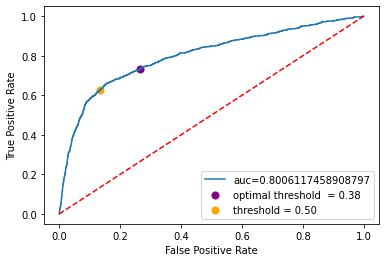

Probabilidade de corte usada: 0.38
Confusion Matrix 
 TN = 3240, FN = 166, TP = 365, FP = 3240 



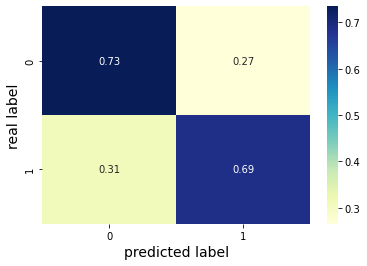


ROC score: 0.7108715658203187

 Accuracy = 0.72931418167105

 Precision (TP/(TP+FP)) = 0.23747560182173064

 Recall (TP/(TP+FN)) = 0.687382297551789

 F1 = 0.3529980657640232


In [26]:
print("\n%%%%%%%%%%%%%%%%%%%%% RANDOM FOREST: %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
model_evaluation(floresta, X_test, y_test, X_val, y_val, "random_forest")

# **Considerações Finais**

De acordo com as métricas usadas, o **random forest apresenta o melhor desempenho**. Há um bom ganho de acurácia, bem como demais indicadores, comparando os modelos com o *dummy classifier*. No entanto os três modelos apresentam resultados parecidos permitindo que o modelo possa ser escolhido de acordo com prioridades do negócio como nível interpretabilidade ou com requisitos mais técnicos como tempo de execução.

Embora chame a atenção os baixos valores da métrica de precisão, isso apenas ocorre devido ao alto número de clientes que não assinam o produto (desbalanceamento inicial da base), que indirtamente leva a um aumento do número total de falsos positivos. Com os modelo de random forest a cada 100 clientes contactados em média 24 vão fechar negócio. Logo, apesar da precisão medida ser baixa, esse resultado corresonde a um **aumento de mais de 100% na eficiência de vendas pelo telemarketing**, que antes era de cerca de 11% (11 a cada 100 clientes fecham negócio).

Já quanto ao recall, apesar do valor obtido parecer bom (69% no random forest), acredito ser um resultado preocupante no caso da empresa possuir uma base limitada de clientes pra entrar em contato. Esse **modelo descarta 31 de cada 100 clientes que assinariam o produto**, podendo levar a uma redução considerável do número de vendas e consequentemente lucro. Dessa forma, só é recomendável a adoção do modelo se a empresa tiver uma base com uma quantidade de clientes acima da capacidade do atendimento via telemarketing e haja a **necessidade de priorizar para quais clientes fazer a oferta**.

In [27]:
#Percentual de clientes que fecharam negócio na base histórica:
100*sum(df['y'])/len(df['y'])

11.26541711178013